In [1]:
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.transform import rotate

In [2]:
def give_me_Pytorch_data_form(input_image, input_labels,torch_format=True):
    whole_length = len(input_image[0])
    width = int(np.sqrt(whole_length))
    image_matrix = np.zeros((len(input_image),1,width,width))
    labels_matrix = np.zeros((len(input_image),10))
    for i in range(0,len(input_image)):
        image_matrix[i,0,:,:]=input_image[i].reshape(width,width)
        labels_matrix[i,input_labels[i]]=1.
    
    if torch_format==True:
        image_matrix = torch.from_numpy(np.array(image_matrix,dtype=np.float32))
        labels_matrix = torch.from_numpy(np.array(labels_matrix,dtype=np.float32))

    return image_matrix,labels_matrix

In [3]:
train = pf.open('Training.fits')
test = pf.open('Test.fits')

In [4]:
image_train, image_labels = give_me_Pytorch_data_form(train[0].data,train[1].data,torch_format=True)
image_test, test_labels = give_me_Pytorch_data_form(test[0].data,test[1].data)

In [126]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ### 
        ### input 1x8x8 
        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8,kernel_size=3,padding=1,stride=1), #8x8x8
            torch.nn.BatchNorm2d(8),
            #torch.nn.MaxPool2d(kernel_size=2), #20x4x4
            torch.nn.ReLU(),
            )
        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=8, out_channels=8,kernel_size=3,padding=1,stride=1),#8x8x8 
            torch.nn.BatchNorm2d(8),
            #torch.nn.MaxPool2d(kernel_size=2), #20x4x4
            torch.nn.ReLU(),
        
        )
        self.cnn3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=8, out_channels=8,kernel_size=3,padding=1,stride=1),#8x9x9 
            torch.nn.BatchNorm2d(8),
            #torch.nn.MaxPool2d(kernel_size=2), #20x4x4
            torch.nn.ReLU(),
        
        )
        self.cnn4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=8, out_channels=8,kernel_size=3,padding=1,stride=1),#8x8x8 
            torch.nn.BatchNorm2d(8),
            #torch.nn.MaxPool2d(kernel_size=2), #20x4x4
            torch.nn.ReLU(),
        
        )
        
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(648, 300)
           )
        self.fc2 = torch.nn.Sequential(
             torch.nn.Linear(300, 150)
           )
        self.fc3 = torch.nn.Sequential(
             torch.nn.Linear(150, 10)
           )
              
        #self.fc2 = torch.nn.Linear(10, 10)
    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x) 
    
        out = x
        return out

In [127]:
model = CNN()

In [128]:
learningRate = 0.01
epochs = 100
criterion = torch.nn.CrossEntropyLoss()
# Just the loss function : here we use the default CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [129]:
accuracy_array = []
accuracy_test_array = []
loss_array = []
loss_test_array = []
epoch_array = []
N_total_train = len(image_train)
batch_size=64
for epoch in range(epochs):
    
    model.train() # here is to tell the code to do the training again after model.eval() mode
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    for start_index_batch in range(0,N_total_train,batch_size):
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()
        end_index = min(start_index_batch + batch_size, N_total_train)
        # get output from the model, given the inputs
        #print(len(color_train[start_index_batch:end_index,:]))
        outputs = model(image_train[start_index_batch:end_index])
        
        # get loss for the predicted output
        loss = criterion(outputs, image_labels[start_index_batch:end_index,:])
        # get gradients w.r.t to parameters
        loss.backward()
        # update parameters
        optimizer.step()
        
    model.eval() # here is to fix the parameters (mean, sigma) of the batchnormalization, given that the batchnorm calculates the mean sigma with a new batch everytime during training. 
    with torch.no_grad():   
        outputs_all = model(image_train)
        pred_y = torch.max(outputs_all, 1)[1].data.squeeze()
        accuracy = torch.sum((pred_y == torch.max(image_labels, 1)[1].data.squeeze()) / pred_y.size(0))
        epoch_array.append(epoch)

        loss_array.append(float(loss.detach().numpy()))
        accuracy_array.append(float(accuracy.numpy()))


        outputs_test = model(image_test) 
        loss_test = criterion(outputs_test, test_labels)

        pred_y_test = torch.max(outputs_test, 1)[1].data.squeeze()
        accuracy_test = torch.sum((pred_y_test == torch.max(test_labels, 1)[1].data.squeeze()) / pred_y_test.size(0))
        accuracy_test_array.append(float(accuracy_test.numpy()))
        loss_test_array.append(float(loss_test.detach().numpy()))

    if epoch % 1 ==0:
        print(epoch,accuracy.numpy(),loss.detach().numpy(), accuracy_test.numpy(),loss_test.detach().numpy())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x800 and 648x300)

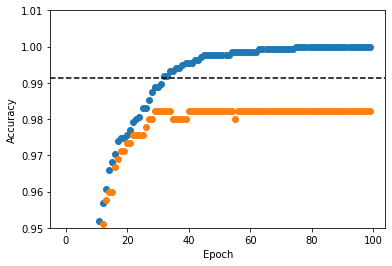

In [125]:
plt.scatter(epoch_array,accuracy_array,color='C0')
plt.scatter(epoch_array,accuracy_test_array,color='C1')
plt.ylim(0.95,1.01)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axhline(0.9912,ls='--',color='black')